<a href="https://colab.research.google.com/github/amitnits2016/fastai/blob/master/EmergencyVsNon/EmergencyVsNon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import warnings
warnings.filterwarnings('ignore')

In [4]:
path = '/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/'

In [5]:
data = ImageDataBunch.from_folder(path, train='train_images', test='test_images', ds_tfms=get_transforms(), seed=1, valid_pct=0.2, bs=64, size=224
                                  ).normalize(imagenet_stats)

In [6]:
data

ImageDataBunch;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
emergency,emergency,emergency,emergency,emergency
Path: /content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
emergency,non_emergency,non_emergency,emergency,non_emergency
Path: /content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification;

Test: LabelList (706 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification

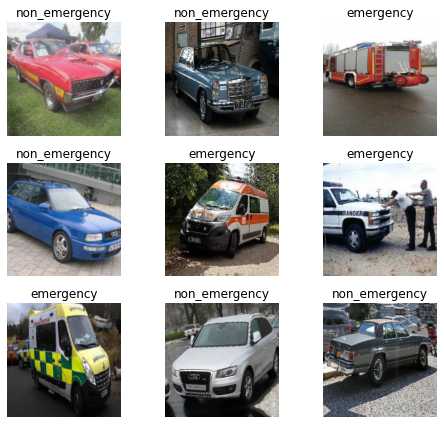

In [7]:
data.show_batch(rows=3, figsize=(7, 6))

In [8]:
print(data.classes)
len(data.classes)

['emergency', 'non_emergency']


2

In [9]:
learn_resnet34 = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [10]:
learn_resnet34.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
learn_resnet34.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,0.829409,0.335133,0.869301,09:51
1,0.550735,0.335700,0.893617,00:24
2,0.425325,0.242268,0.924012,00:14
3,0.335577,0.274698,0.924012,00:14
4,0.286476,0.252909,0.914894,00:14
5,0.243270,0.248500,0.933131,00:14
6,0.209479,0.219619,0.930091,00:14
7,0.180916,0.241974,0.908815,00:14
8,0.169928,0.224887,0.914894,00:14
9,0.148119,0.244787,0.920973,00:14


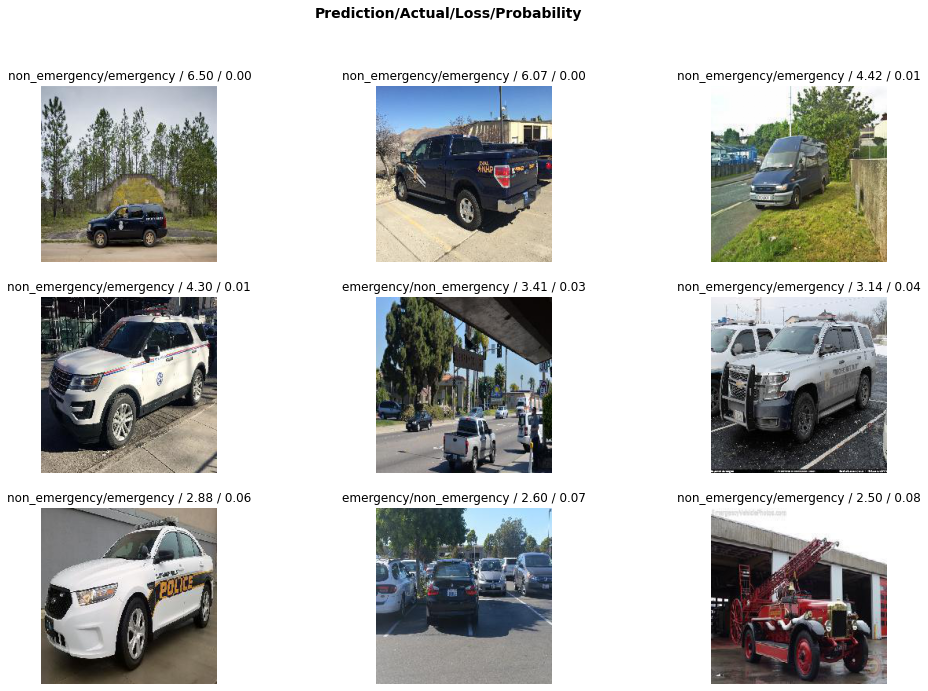

In [13]:
interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet34)
interp_resnet34.plot_top_losses(9, figsize=(17,11))

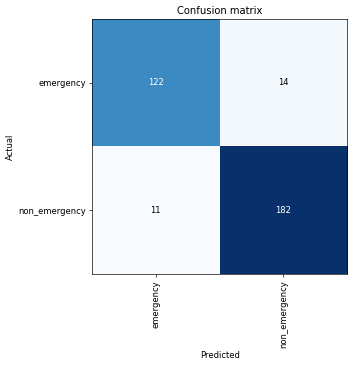

In [14]:
interp_resnet34.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [38]:
import pandas as pd
sub_file = pd.read_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/test_images_actual_label.csv')
sub_file.head()

,image_names,emergency_or_not
0,100.jpg,1
1,105.jpg,1
2,109.jpg,1
3,111.jpg,1
4,115.jpg,1


In [16]:
sub_file['emergency_or_not'].value_counts()

0    396
1    310
Name: emergency_or_not, dtype: int64

In [18]:
p1 = learn_resnet34.predict(data.test_ds.x[0])
print(p1)
print("label",int(p1[0]))
print("label",str(p1[0]))

(Category tensor(1), tensor(1), tensor([0.4385, 0.5615]))
label 1
label non_emergency


In [19]:
preds = []
filename = []
for i in range(0,706):
    f = str(learn_resnet34.data.test_ds.items[i]).split('/')[-1]
    p = learn_resnet34.predict(data.test_ds.x[i])
    filename.append(f)    
    preds.append(int(p[0]))

In [39]:
df1=pd.DataFrame(list(zip(filename,preds)),columns=['image_names','pred_res34'])
df1.head()

,image_names,pred_res34
0,192.jpg,1
1,1750.jpg,1
2,1772.jpg,1
3,1868.jpg,0
4,1847.jpg,1


In [46]:
sub_file = pd.merge (sub_file,df1,on='image_names')
sub_file.head(10)

,image_names,emergency_or_not,pred_res34
0,100.jpg,1,0
1,105.jpg,1,0
2,109.jpg,1,0
3,111.jpg,1,0
4,115.jpg,1,0
5,118.jpg,1,0
6,120.jpg,1,0
7,121.jpg,1,0
8,124.jpg,1,0
9,128.jpg,1,0


In [47]:
sub_file['diff_res34'] = abs(sub_file['emergency_or_not'] - sub_file['pred_res34'])
sub_file.head()

,image_names,emergency_or_not,pred_res34,diff_res34
0,100.jpg,1,0,1
1,105.jpg,1,0,1
2,109.jpg,1,0,1
3,111.jpg,1,0,1
4,115.jpg,1,0,1


In [48]:
sub_file['diff_res34'].value_counts(normalize=True)*100

1    94.050992
0     5.949008
Name: diff_res34, dtype: float64

In [12]:
learn_resnet34.save('learn_resnet34-1')

In [49]:
sub_file.to_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/result_res34.csv')

In [50]:
sub_file = pd.read_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/test_images_actual_label.csv')

epoch,train_loss,valid_loss,accuracy,time
0,0.490686,0.348157,0.890577,00:15
1,0.374360,0.328934,0.924012,00:15
2,0.309703,0.375830,0.920973,00:15
3,0.264701,0.394415,0.902736,00:15
4,0.249341,0.427812,0.917933,00:15
5,0.217121,0.260284,0.914894,00:15
6,0.189592,0.213077,0.927052,00:15
7,0.161660,0.223749,0.930091,00:15
8,0.148183,0.214761,0.942249,00:15
9,0.125260,0.240145,0.933131,00:15


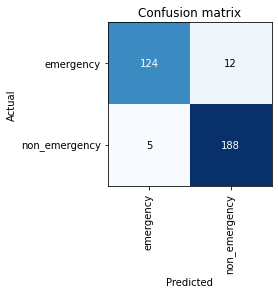

In [55]:
learn_resnet50 = cnn_learner(data, models.resnet50, metrics=accuracy)
learn_resnet50.fit_one_cycle(20)
interp_resnet50 = ClassificationInterpretation.from_learner(learn_resnet50)
interp_resnet50.plot_confusion_matrix( )
preds = []
filename = []
for i in range(0,706):
    f = str(learn_resnet50.data.test_ds.items[i]).split('/')[-1]
    p = learn_resnet50.predict(data.test_ds.x[i])
    filename.append(f)    
    preds.append(int(p[0])) 
df2=pd.DataFrame(list(zip(filename,preds)),columns=['image_names','pred_res50'])
learn_resnet50.save('learn_resnet50-1')

In [56]:
sub_file = pd.merge (sub_file,df2,on='image_names')
sub_file['diff_res50'] = abs(sub_file['emergency_or_not'] - sub_file['pred_res50'])
print(sub_file['diff_res50'].value_counts(normalize=True)*100)
sub_file.to_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/result_res50.csv')
sub_file = pd.read_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/test_images_actual_label.csv')

1    95.042493
0     4.957507
Name: diff_res50, dtype: float64


epoch,train_loss,valid_loss,accuracy,time
0,0.576742,0.218367,0.911854,00:18
1,0.407762,0.228575,0.933131,00:18
2,0.311321,0.285523,0.920973,00:18
3,0.257846,0.259303,0.927052,00:18
4,0.215401,0.326760,0.927052,00:17
5,0.186452,0.280471,0.924012,00:18
6,0.142000,0.273678,0.933131,00:18
7,0.121238,0.268148,0.942249,00:17
8,0.102903,0.277703,0.930091,00:17
9,0.084101,0.288723,0.945289,00:17


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f17320c3080>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f16fe08fa20>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


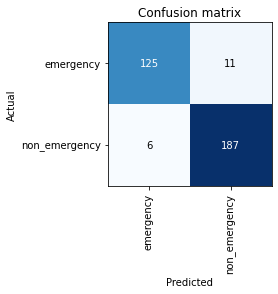

In [59]:
#Create model with densenet169
learn_densenet169= cnn_learner(data, models.densenet169, metrics=accuracy)
learn_densenet169.fit_one_cycle(20)
interp_densenet169 = ClassificationInterpretation.from_learner(learn_densenet169)
interp_densenet169.plot_confusion_matrix( )
preds = []
filename = []
for i in range(0,706):
    f = str(learn_densenet169.data.test_ds.items[i]).split('/')[-1]
    p = learn_densenet169.predict(data.test_ds.x[i])
    filename.append(f)    
    preds.append(int(p[0]))
  
df3=pd.DataFrame(list(zip(filename,preds)),columns=['image_names','pred_dense169'])
learn_densenet169.save('learn_dense169-1')

In [60]:
sub_file = pd.merge (sub_file,df3,on='image_names')
sub_file['diff_dense169'] = abs(sub_file['emergency_or_not'] - sub_file['pred_dense169'])
print(sub_file['diff_dense169'].value_counts(normalize=True)*100)
sub_file.to_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/result_dense169.csv')
sub_file = pd.read_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/test_images_actual_label.csv')

1    95.609065
0     4.390935
Name: diff_dense169, dtype: float64


epoch,train_loss,valid_loss,accuracy,time
0,0.682679,0.252774,0.902736,00:16
1,0.484701,0.245441,0.914894,00:16
2,0.382457,0.216562,0.939210,00:16
3,0.315207,0.244207,0.920973,00:16
4,0.246628,0.181600,0.945289,00:16
5,0.211774,0.159908,0.957447,00:16
6,0.190711,0.209183,0.942249,00:17
7,0.161991,0.187115,0.951368,00:16
8,0.134494,0.189144,0.948328,00:16
9,0.117657,0.150249,0.966565,00:16


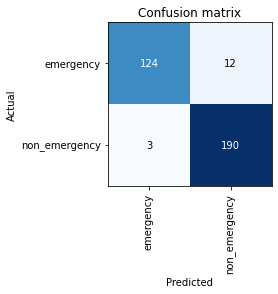

In [62]:
#Create model with densenet121
learn_densenet121= cnn_learner(data, models.densenet121, metrics=accuracy)
learn_densenet121.fit_one_cycle(20)
interp_densenet121 = ClassificationInterpretation.from_learner(learn_densenet121)
interp_densenet121.plot_confusion_matrix( )
preds = []
filename = []
for i in range(0,706):
    f = str(learn_densenet121.data.test_ds.items[i]).split('/')[-1]
    p = learn_densenet121.predict(data.test_ds.x[i])
    filename.append(f)    
    preds.append(int(p[0]))
  
df4=pd.DataFrame(list(zip(filename,preds)),columns=['image_names','pred_dense121'])
learn_densenet121.save('learn_dense121-1')

In [63]:
sub_file = pd.merge (sub_file,df4,on='image_names')
sub_file['diff_dense121'] = abs(sub_file['emergency_or_not'] - sub_file['pred_dense121'])
print(sub_file['diff_dense121'].value_counts(normalize=True)*100)
sub_file.to_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/result_dense121.csv')
sub_file = pd.read_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/test_images_actual_label.csv')

1    95.892351
0     4.107649
Name: diff_dense121, dtype: float64


# **Unfreeze the layer and tune the learning rate for resnet_50 and train the model**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


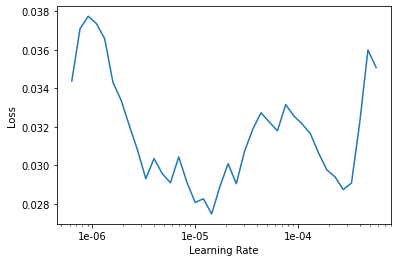

In [64]:
#Lets unfreeze the layer and tune the learning rate for resnet_50
learn_resnet50.unfreeze()
learn_resnet50.lr_find()
learn_resnet50.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.042107,0.231401,0.948328,00:16
1,0.036679,0.227304,0.945289,00:16
2,0.029797,0.219430,0.942249,00:16
3,0.031339,0.203047,0.957447,00:16
4,0.030840,0.191240,0.954407,00:16
5,0.038223,0.194741,0.951368,00:16
6,0.040424,0.213629,0.948328,00:16
7,0.038305,0.226021,0.945289,00:16
8,0.035121,0.167282,0.963526,00:16
9,0.034693,0.191124,0.963526,00:16


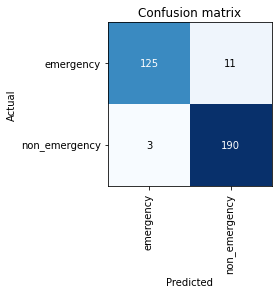

In [65]:
learn_resnet50.fit_one_cycle(20,max_lr=slice(1e-6,8e-4))
interp = ClassificationInterpretation.from_learner(learn_resnet50)
interp.plot_confusion_matrix( )
preds = []
filename = []
for i in range(0,706):
    f = str(learn_resnet50.data.test_ds.items[i]).split('/')[-1]
    p = learn_resnet50.predict(data.test_ds.x[i])
    filename.append(f)    
    preds.append(int(p[0]))  
df5=pd.DataFrame(list(zip(filename,preds)),columns=['image_names','pred_resnet50'])
learn_resnet50.save('learn_resnet50_updated')

In [66]:
sub_file = pd.merge (sub_file,df5,on='image_names')
sub_file['diff_resnet50'] = abs(sub_file['emergency_or_not'] - sub_file['pred_resnet50'])
print(sub_file['diff_resnet50'].value_counts(normalize=True)*100)
sub_file.to_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/result_resnet50.csv')
sub_file = pd.read_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/test_images_actual_label.csv')

1    96.033994
0     3.966006
Name: diff_resnet50, dtype: float64


In [ ]:
learn.freeze()
learn.save('BinaryImageClassification')